In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from fastdtw import fastdtw
from sklearn.cluster import DBSCAN

import seaborn as sns
from scipy.spatial.distance import euclidean
import scipy.cluster.hierarchy
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.metrics import mean_squared_error

from scipy.spatial.distance import cdist
import warnings#
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', 500)

In [2]:
data = pd.read_csv('final.csv') 
data

,Driver,ID,Time(ms),Position_x,Position_y,Position_z,Rotation_x,Rotation_y,Rotation_z,Rotation_w,Speed (km/h),Steering Wheel Position_-1,Steering Wheel Position_1,Gas Pedal Position,Brake Pedal Position,Engine Running,Distance Ahead (meters),Time To Collision (sec),Headway Time (sec)
0,p2,T-74,1,-1.949,0.136,184.128,-0.0006,0.9999,-0.0006,-0.0149,20.92,0.03073,0.730480,0.000000,True,0,0,0,0.054071
1,p2,T-74,2,-1.939,0.136,184.362,-0.0006,0.9999,-0.0006,-0.0162,21.14,0.03315,0.726574,0.000000,True,0,0,0,0.060681
2,p2,T-74,3,-1.927,0.136,184.598,-0.0006,0.9998,-0.0006,-0.0177,21.36,0.03538,0.726574,0.000000,True,0,0,0,0.077581
3,p2,T-74,4,-1.902,0.136,185.078,-0.0006,0.9998,-0.0006,-0.0209,21.81,0.03913,0.726574,0.000000,True,0,0,0,0.076490
4,p2,T-74,5,-1.887,0.136,185.321,-0.0007,0.9997,-0.0006,-0.0226,22.03,0.04101,0.726574,0.000000,True,0,0,0,0.087563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51340,p5,T-41,3026,1063.240,0.136,1314.943,0.0003,-0.6977,-0.0003,0.7164,33.73,-0.00016,0.000000,0.273808,True,0,0,0,-1.730747
51341,p5,T-41,3027,1063.609,0.136,1314.933,0.0003,-0.6976,-0.0003,0.7164,32.98,-0.00074,0.000000,0.142855,True,0,0,0,-1.269858
51342,p5,T-41,3028,1063.972,0.136,1314.923,0.0004,-0.6977,-0.0002,0.7164,32.49,-0.00200,0.000000,0.000000,True,0,0,0,-0.850367
51343,p5,T-41,3029,1064.331,0.136,1314.914,0.0005,-0.6977,-0.0001,0.7164,32.31,-0.00200,0.000000,0.000000,True,0,0,0,-0.390502


In [3]:
data = data.fillna(data.mean()) #goot type of filling missing data
# 把 driver attribute 转化为 int 类型
def diffDrivers(x):
    num=int(x[1:])
        
    return num

data['Driver'] = data['Driver'].map( lambda x: diffDrivers(x))

In [4]:
# 区分开不同的 time series
sliceStart=[]

for i in range(0, len(data)):
    if data.iloc[i]['Time(ms)']==1:
        sliceStart.append(i)
    
sliceStart.append(len(data)-1)
sliceStart  

[0,
 2656,
 4885,
 7165,
 9697,
 12598,
 16502,
 20156,
 23260,
 27501,
 29829,
 32397,
 35033,
 38465,
 41819,
 45417,
 48315,
 51344]

In [5]:
# data drop
data['Target Variable']=data['Driver'].astype(str)+'_'+data['ID']+'_'+data['Time(ms)'].astype(str)

data=data.drop(["ID","Position_y"," Brake Pedal Position "," Gas Pedal Position "," Engine Running "," Distance Ahead (meters)"," Time To Collision (sec) "],axis=1)

In [6]:
data

,Driver,Time(ms),Position_x,Position_z,Rotation_x,Rotation_y,Rotation_z,Rotation_w,Speed (km/h),Steering Wheel Position_-1,Steering Wheel Position_1,Headway Time (sec),Target Variable
0,2,1,-1.949,184.128,-0.0006,0.9999,-0.0006,-0.0149,20.92,0.03073,0.730480,0.054071,2_T-74_1
1,2,2,-1.939,184.362,-0.0006,0.9999,-0.0006,-0.0162,21.14,0.03315,0.726574,0.060681,2_T-74_2
2,2,3,-1.927,184.598,-0.0006,0.9998,-0.0006,-0.0177,21.36,0.03538,0.726574,0.077581,2_T-74_3
3,2,4,-1.902,185.078,-0.0006,0.9998,-0.0006,-0.0209,21.81,0.03913,0.726574,0.076490,2_T-74_4
4,2,5,-1.887,185.321,-0.0007,0.9997,-0.0006,-0.0226,22.03,0.04101,0.726574,0.087563,2_T-74_5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51340,5,3026,1063.240,1314.943,0.0003,-0.6977,-0.0003,0.7164,33.73,-0.00016,0.000000,-1.730747,5_T-41_3026
51341,5,3027,1063.609,1314.933,0.0003,-0.6976,-0.0003,0.7164,32.98,-0.00074,0.000000,-1.269858,5_T-41_3027
51342,5,3028,1063.972,1314.923,0.0004,-0.6977,-0.0002,0.7164,32.49,-0.00200,0.000000,-0.850367,5_T-41_3028
51343,5,3029,1064.331,1314.914,0.0005,-0.6977,-0.0001,0.7164,32.31,-0.00200,0.000000,-0.390502,5_T-41_3029


In [7]:
# Min max scaler from sklearn to normalise the columns
min_max_scaler = preprocessing.MinMaxScaler()
# Selecting all the feature variable columns

matrix = data.loc[:, (data.columns != 'Target Variable')&(data.columns != 'Time(ms)')&(data.columns != 'Driver')]
np_scaled = min_max_scaler.fit_transform(matrix[0:sliceStart[1]])
data_normalized= pd.DataFrame(np_scaled,columns=matrix.columns,
                    index = matrix.index[0:sliceStart[1]])
# 针对不同的 time series 而不是整体分别进行规范化操作
for i in range(1,len(sliceStart)-1):
    if i == (len(sliceStart)-2):
        print(len(sliceStart)-2)
        np_scaled_new = min_max_scaler.fit_transform(matrix[sliceStart[i]:sliceStart[i+1]+1])
        data_normalized_new = pd.DataFrame(np_scaled_new,columns=matrix.columns,
                    index = matrix.index[sliceStart[i]:sliceStart[i+1]+1])
    else:
        np_scaled_new = min_max_scaler.fit_transform(matrix[sliceStart[i]:sliceStart[i+1]])
        data_normalized_new = pd.DataFrame(np_scaled_new,columns=matrix.columns,
                    index = matrix.index[sliceStart[i]:sliceStart[i+1]])
    np_scaled=np.append(np_scaled,np_scaled_new)
    data_normalized=data_normalized.append(data_normalized_new)



    
# ### 传统方法
# min_max_scaler = preprocessing.MinMaxScaler()
# # Selecting all the feature variable columns
# matrix = data.loc[:, data.columns != 'Target Variable']
# np_scaled = min_max_scaler.fit_transform(matrix)
# data_normalized = pd.DataFrame(np_scaled,columns=matrix.columns,
#             index = matrix.index)

16


In [8]:
data_normalized

,Position_x,Position_z,Rotation_x,Rotation_y,Rotation_z,Rotation_w,Speed (km/h),Steering Wheel Position_-1,Steering Wheel Position_1,Headway Time (sec)
0,0.000000,0.000000,0.328358,0.999946,0.357143,0.398218,0.000000,0.742565,0.935018,0.837120
1,0.000013,0.000302,0.328358,0.999946,0.357143,0.397145,0.004772,0.749691,0.930018,0.837616
2,0.000029,0.000607,0.328358,0.999893,0.357143,0.395907,0.009544,0.756257,0.930018,0.838883
3,0.000061,0.001227,0.328358,0.999893,0.357143,0.393267,0.019306,0.767299,0.930018,0.838801
4,0.000081,0.001541,0.313433,0.999839,0.357143,0.391864,0.024078,0.772834,0.930018,0.839631
...,...,...,...,...,...,...,...,...,...,...
51340,0.998652,0.998912,0.622807,0.088141,0.480000,0.991654,0.093971,0.186269,0.000000,0.277770
51341,0.998995,0.998903,0.622807,0.088194,0.480000,0.991654,0.085408,0.183637,0.000000,0.397430
51342,0.999333,0.998894,0.631579,0.088141,0.500000,0.991654,0.079813,0.177920,0.000000,0.506341
51343,0.999666,0.998886,0.640351,0.088141,0.520000,0.991654,0.077757,0.177920,0.000000,0.625735


In [9]:
# selecting the target variable column
driverAndId = data['Target Variable'].to_frame()

driver_id_time=driverAndId.merge(data['Time(ms)'], how='outer', left_index=True, right_index=True)

driver_id_time=driver_id_time.merge(data['Driver'], how='outer', left_index=True, right_index=True)

# Final normalised dataset
data = driver_id_time.merge(data_normalized, how='outer', left_index=True, right_index=True)
# Selecting all the feature variable columns
matrix = data.loc[:, (data.columns != 'Target Variable')&(data.columns != 'Time(ms)')&(data.columns != 'Driver')]

In [10]:
driver_id_time

,Target Variable,Time(ms),Driver
0,2_T-74_1,1,2
1,2_T-74_2,2,2
2,2_T-74_3,3,2
3,2_T-74_4,4,2
4,2_T-74_5,5,2
...,...,...,...
51340,5_T-41_3026,3026,5
51341,5_T-41_3027,3027,5
51342,5_T-41_3028,3028,5
51343,5_T-41_3029,3029,5


In [11]:
# Applying PCA based dimentionality reduction
pca = PCA(n_components=3)
pca.fit(matrix)

columns = ['pca_%i' % i for i in range(3)]
pca_df = pd.DataFrame(pca.transform(matrix), columns=columns, index=data.index)
final = driverAndId.merge(pca_df, how='outer', left_index=True, right_index=True)

print (pca.explained_variance_ratio_)
print (pca.explained_variance_)
print (pca.n_components_)

[0.41256941 0.1888638  0.16226568]
[0.3825031  0.17510021 0.15044045]
3


In [12]:
final

,Target Variable,pca_0,pca_1,pca_2
0,2_T-74_1,0.878149,0.029733,0.618897
1,2_T-74_2,0.878915,0.032366,0.619466
2,2_T-74_3,0.879955,0.033880,0.621817
3,2_T-74_4,0.882090,0.036101,0.625628
4,2_T-74_5,0.886050,0.039458,0.627025
...,...,...,...,...
51340,5_T-41_3026,-0.820072,0.388418,-0.348702
51341,5_T-41_3027,-0.821139,0.390341,-0.339574
51342,5_T-41_3028,-0.828687,0.388080,-0.330989
51343,5_T-41_3029,-0.835723,0.387223,-0.319194


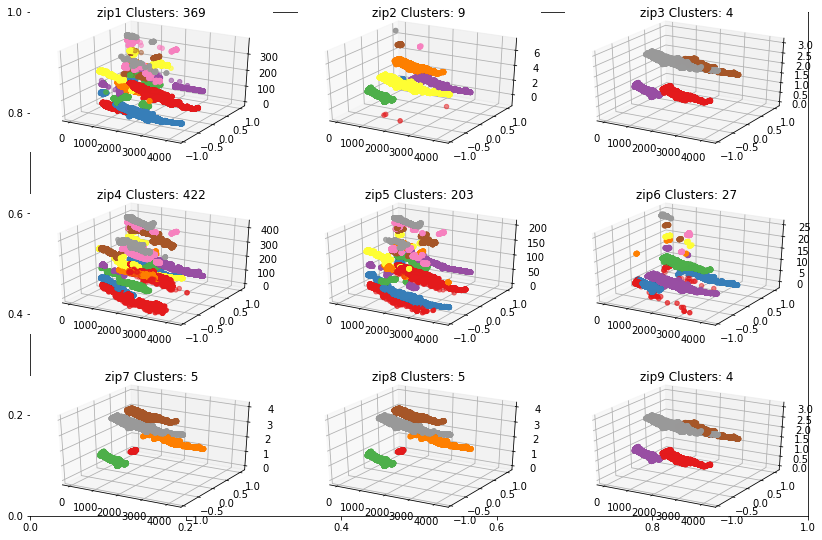

In [13]:
# Using DBSCAN for learning purposes
# Setting hyperparemeters for DBSCAN
# epsValues = [0.05,0.1,0.2,0.05,0.1,0.2,0.05,0.1,0.2]
# min_samples_Value = [1,1,1,5,5,5,9,9,9]
# Other possible values
epsValues = [0.125,0.25,0.5,0.1,0.123,0.2,0.3,0.4,0.5]
min_samples_Value = [1,2,3,4,5,6,7,8,9]
# epsValues = [1,2,3,1,2,3,1,2,3]
# min_samples_Value = [2,2,2,3,3,3,5,5,5]



# Loop to evaluate DBSCAN on various different hyperparameters and plot it
fig, ax = plt.subplots(figsize=(18,10))
i = 1
for esp, min_samples in zip(epsValues,min_samples_Value):
    # --------这里的 DBSCAN() 默认使用欧式距离，我们要尝试使用不同的距离函数-------
    dbscan = DBSCAN(eps=esp, min_samples = min_samples)
    dbscanClusters = dbscan.fit_predict(matrix)
    plt.subplots_adjust(left=0.2, bottom=0.2, right=0.8, top=0.9,
                wspace=0.1, hspace=0.3)

    ax=fig.add_subplot(3,3,i, projection='3d')

    scatter=ax.scatter(data["Time(ms)"], pca_df['pca_0'],dbscanClusters, c=dbscanClusters,cmap="Set1")
    
    num = len(np.unique(dbscanClusters))
    plt.title("zip"+ str(i)+" "+"Clusters: "+str(num))
    i += 1
plt.savefig("DBSCAN_30Drivers.png")
plt.show()


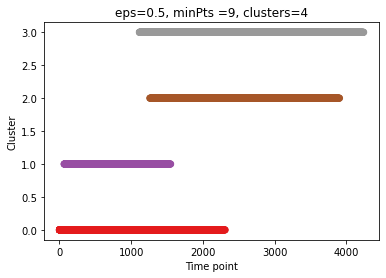

In [14]:
# Get DBSCAN prediction based on most appropriate cluster infered from the graph
eps_value=0.5
min_samples_value=9

dbscan = DBSCAN(eps=eps_value, min_samples = min_samples_value)
dbscanClusters = dbscan.fit_predict(matrix)
labels = dbscanClusters
pca_df['DBSCAN_Labels'] = dbscanClusters

sizes=40*(data['Driver'].astype(int))

plt.scatter(data["Time(ms)"], dbscanClusters, c= dbscanClusters,alpha=0.3,cmap="Set1")
num = len(np.unique(dbscanClusters))
plt.title("eps="+str(eps_value)+", minPts ="+str(min_samples_value)+", clusters="+str(num))
plt.xlabel('Time point')
plt.ylabel('Cluster')
plt.show()

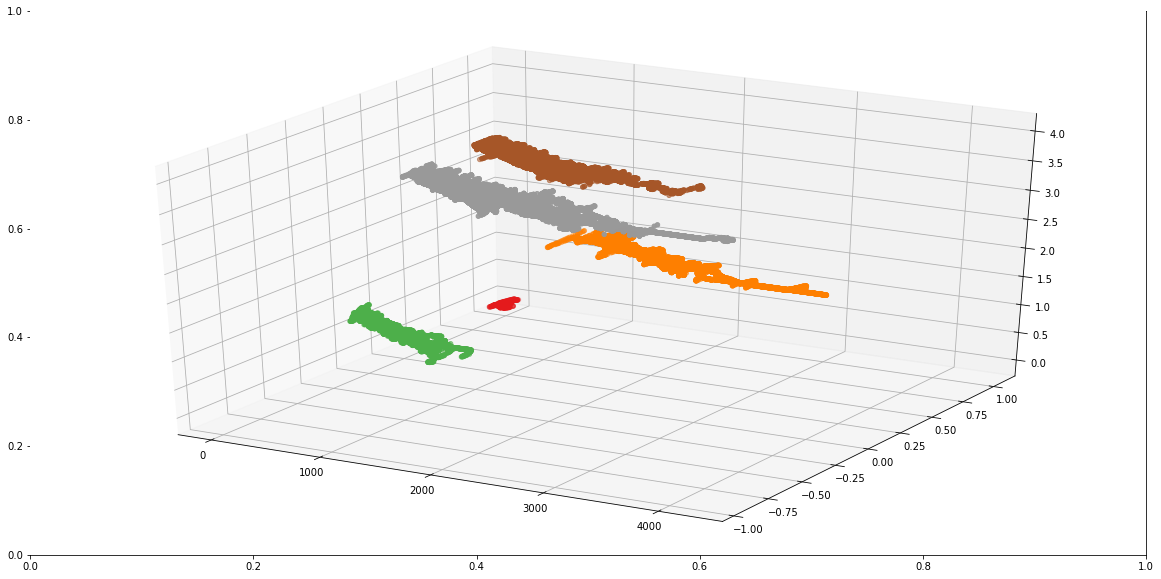

In [15]:
# Get DBSCAN prediction based on most appropriate cluster infered from the graph
eps_value=0.4
min_samples_value=8

dbscan = DBSCAN(eps=eps_value, min_samples = min_samples_value)
dbscanClusters = dbscan.fit_predict(matrix)
labels = dbscanClusters
pca_df['DBSCAN_Labels'] = dbscanClusters



fig, ax = plt.subplots(figsize=(20,10))
ax=fig.add_subplot(111, projection='3d')

# ax.view_init(10, 90)


scatter=ax.scatter(data["Time(ms)"], pca_df['pca_0'],dbscanClusters,  c= dbscanClusters,cmap="Set1")
# ax.set_xlabel("Time",fontsize=13)
# ax.set_ylabel("PCA_0",fontsize=13)
# ax.set_zlabel("Clusters",fontsize=13)

# plt.scatter(data["Time(ms)"], pca_df['pca_0'], pca_df['pca_1'], c= dbscanClusters,cmap="viridis")
num = len(np.unique(dbscanClusters))
# plt.title("DBSCAN based "+str(num)+  " clusters eps="+str(eps_value)+", min_samples ="+str(min_samples_value))
plt.show()